<span style="font-size: 28px; font-weight: bold;">MRI reconstruction using Deep Learning-Based Proximal Gradient Descent</span>

 ![intro](figures/intro_image.jpg)                                                                        

<span style="font-size: 24px; font-weight: bold;">Table of contents</span>

- [Introduction: MRI Data Acquisition Challenges](#introduction)
- [Compressed sensing](#compressed-sensing)
- [Neural Proximal Gradient Descent](#NPGD)
- [Suggestions for follow-up work and variations](#suggestions)

Note: Press the button 'Run section' in the live editor tab to sequencially run the code provided below at each
section.

<a id="introduction"></a>
# Introduction: MRI Data Acquisition Challenges

A transformative approach has been witnessed in the field of medical imaging, particularly magnetic resonance imaging (MRI), due to its potential to address fundamental challenges associated with data acquisition and reconstruction. In the context of MRI, the process relies on capturing k-space measurements, akin to a two-dimensional Fourier transform of an image, which subsequently undergoes inverse Fourier transformation to generate high-resolution images of the body's internal tissues. However, what distinguishes MRI from other imaging modalities is the substantial amount of data it acquires. For instance, a considerable memory footprint can be observed in the k-space representation of an MRI scan, often exceeding hundreds of kilobytes, while the corresponding image in JPEG format occupies significantly less storage space, typically in the order of a few kilobytes. A compelling proposition is raised by Compressed Sensing theory: if the image data can be efficiently compressed later in the processing pipeline, fewer k-space measurements can be acquired, ultimately reducing scan time and improving patient comfort [1].

To realize this promise of more efficient data acquisition in MRI, Accelerated MRI techniques have been developed, aiming to streamline the acquisition process by acquiring significantly fewer k-space measurements while maintaining image quality and diagnostic accuracy. Achieving such acceleration in MRI reconstruction involves the application of innovative methods, often rooted in advanced deep learning and optimization techniques [1]. In this project, a specific approach proposed in the paper "Regularization by Architecture: A Deep Prior Approach for Inverse Problems" [2] is delved into, which leverages deep learning and Proximal Gradient Descent to enhance the efficiency of deep image prior techniques in the context of ill-posed inverse problems.

The Facebook and NYU fastMRI dataset [3] will be utilized as the source of MRI data. This dataset is quite extensive, amounting to 88 GB. To facilitate the work, a down-sampled version has been prepared, comprising 995 MRI images of knees. Additionally, a train-test split has already been implemented, encompassing 750 images for training and 245 images for testing. These images originate from 150 subjects for training and 49 subjects for testing.

[1] "Generalized Deep Learning-Based Proximal Gradient Descent for MR Reconstruction", https://link.springer.com/chapter/10.1007/978-3-031-34344-5_28   
[2] "Regularization by Architecture: A Deep Prior Approach for Inverse Problems", https://link.springer.com/article/10.1007/s10851-019-00923-x                       
[3] https://fastmri.org/

<a id="compressed-sensing"></a>
# Compressed sensing

Images of tissues inside the body can be created utilizing what are known as k-space measurements due to the mechanics of how an MRI machine works. Because k-space is analogous to the 2D-Fourier transform of an image, we can generate an image from a k-space measurement using the 2D inverse Fourier transform:

![Inverse FFT](figures/inverse_fft.png)     

One odd aspect of MRI pictures is that we collect a large amount of data; the k-space above has a memory footprint of 800 KB. However, the image above is merely 16 KB in jpeg format. According to compressed sensing theory, we should have done better; if we could compress the image later in the pipeline, we should be able to take fewer measurements. Accelerated MRI attempts to deliver on that promise by taking fewer K-space measurements.

![K-space Inverse FFT](figures/k_space_inverse_fft.png)   

In order to obtain the reconstructed image, we effectively use the following equation:

$$ Y = \left| F^{-1} (M \odot (F(X) + N)) \right| $$

Where,  
F signifies the 2D Fourier Transform,  
F−1 signifies the inverse 2D Fourier Transform,  
X is the ground-truth fully acquired MRI image,  
Y is the accelerated measurement,  
N is measurement noise,  
M is the measurement mask, consisting of ones and zeros to under-sample k-space.  
Moreover, the operator, ⊙, is element-wise multiplication. Finally, it's important to highlight that we use the absolute value operation because the inverse Fourier transform produces an imaginary signal when working with partial k-space measurements. The entire process described by this equation can be visualized through the following pipeline.

![Pipeline](figures/pipeline.png)

First we start with the imports.

In [1]:
# libraries
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

# local imports
#sys.path.append('./code/')
import Fast_MRI_dataloader
import MRI_helper
import Neural_proximal_GD

The code block below we will recreate the pipeline.

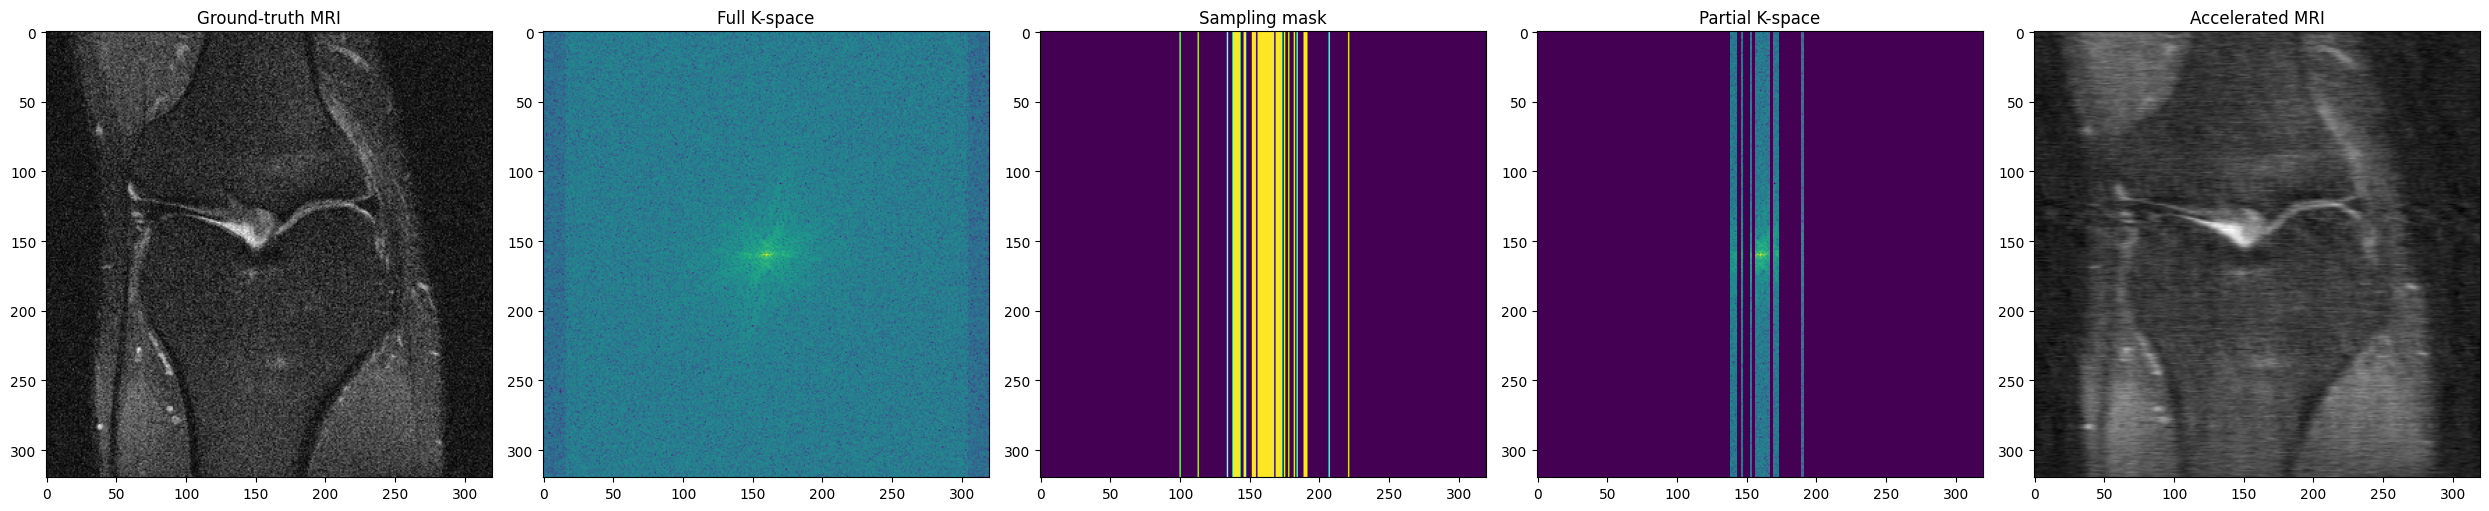

In [2]:
# define parameters
data_dir = './data/'
batch_size = 64

# get dataloader
train_loader, test_loader = Fast_MRI_dataloader.get_dataloaders(data_dir, batch_size)

# get the first batch from the train loader
first_batch = next(iter(train_loader))
kspace, mask, ground_truth = first_batch

# pipeline
# take the first ground truth image and corresponding measurement matrix of first batch
gt_image = ground_truth[0]
M_mat = mask[0]

# calculate the K-space for the image
image_k_space = MRI_helper.calculate_k_space(gt_image)
# calculate the log of the absolute value of K-space tensor
image_k_space_log = torch.log(torch.abs(image_k_space))

# calculate the partial K-space for the image
partial_k_space = MRI_helper.calculate_partial_k_space(image_k_space, M_mat)
# calculate the log of the absolute value of partial K-space tensor
image_partial_k_space_log = torch.log(torch.abs(partial_k_space))

# create the accelerated MRI from partial K-space
acc_MRI = MRI_helper.accelarate_MRI(partial_k_space).abs()

# plot the pipeline
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
cmap = plt.colormaps['viridis']
cmap.set_bad(cmap(0))

# plot the ground truth image
axs[0].imshow(gt_image, cmap='gray')
axs[0].set_title('Ground-truth MRI')

# plot the log of the absolute value of the K-space
axs[1].imshow(image_k_space_log, cmap=cmap)
axs[1].set_title('Full K-space')

# plot the measurement mask
axs[2].imshow(M_mat, cmap=cmap)
axs[2].set_title('Sampling mask')

# plot the partial k-space
axs[3].imshow(image_partial_k_space_log, cmap=cmap)
axs[3].set_title('Partial K-space')

# plot the accelerated MRI
axs[4].imshow(acc_MRI, cmap='gray')
axs[4].set_title('Accelerated MRI')

# display the figure
plt.tight_layout()
plt.show()

<a id="NPGD"></a>
# Neural Proximal Gradient Descent

Before we start training our model, lets firstly explain how the Neural Proximal Gradient Descent algorithm works. In the figure below, there is a simpler version of the algorithm, which is for 2 unfolding iterations.

![Neural proximal gradient decent](figures/NPGD.png)  

In the figure above, the greek letter φ represents the proximal operator, which in our case is a neural network, that consists of 4 convolutional layers with kernel size of 3 and ReLU activation functions.  Additionally, our algorithm is designed to unfold 5 times instead of 2, as shown in the figure.

Now let's define the parameters of the algorithm for the training. The batch size determines the number of data samples that will be processed in each iteration during the training of the model. The number of epochs represents the number of times the entire dataset will be used to train the model. Each pass through the entire dataset is known as an epoch. The learning rate is a crucial hyperparameter that controls the step size during the optimization process. It influences how quickly the model converges and whether it reaches an optimal solution. Lastly, the hyperparameter lamda is a positive number and controls how much of the original input and how much of the output of the previous unfold we are going to take into account in the current unfolding of the algorithm.

In [3]:
# define parameters
batch_size = 8
no_epochs = 20
learning_rate = 1e-4
lamda = 0.4

# set device to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# get dataloader
train_loader, test_loader = Fast_MRI_dataloader.get_dataloaders(data_dir, batch_size)

# create the ProxNet network
prox_net_model = Neural_proximal_GD.prox_net().to(device)

# create the optimizer
optimizer = torch.optim.Adam(prox_net_model.parameters(), lr=learning_rate)

Device: cuda


Now let's train our model.

In [4]:
# training loop
train_loss_list = []
test_loss_list = []

# go over all epochs
for epoch in range(no_epochs):
    epoch_train_loss = 0
    print(f"\nTraining Epoch {epoch}:")
    # go over all minibatches
    for batch_idx, (train_kspace, train_M, train_gt) in enumerate(tqdm(train_loader)):

        # # add an extra dimension to the input tensors
        train_kspace = train_kspace.unsqueeze(1).to(device)
        train_M = train_M.unsqueeze(1).to(device)
        train_gt = train_gt.unsqueeze(1).to(device)

        # reset the gradients of the optimizer
        optimizer.zero_grad()

        train_output = prox_net_model(train_kspace, train_M, lamda).to(device)

        # calculate the MSE loss
        train_loss = torch.nn.functional.mse_loss(train_output, train_gt)

        # perform backpropagation
        train_loss.backward()

        # do an update step
        optimizer.step()

        epoch_train_loss += train_loss.item()

    # append loss to list after each epoch
    train_loss_list.append(train_loss.item())

    # evaluate on the entire test set
    with torch.no_grad():
        epoch_test_loss = 0
        for batch_idx, (test_kspace, test_M, test_gt) in enumerate(tqdm(test_loader)):
            # add an extra dimension to the input tensors
            test_M = test_M.unsqueeze(1).to(device)
            test_kspace = test_kspace.unsqueeze(1).to(device)
            test_gt = test_gt.unsqueeze(1).to(device)

            test_output = prox_net_model(test_kspace, test_M, lamda)

            # calculate the SSIM loss
            test_loss = torch.nn.functional.mse_loss(test_output, test_gt)

            epoch_test_loss += test_loss.item()

        # calculate average testing loss for the epoch
        epoch_test_loss /= len(test_loader)
        test_loss_list.append(epoch_test_loss)


Training Epoch 0:


100%|██████████| 31/31 [00:05<00:00,  5.94it/s]



Training Epoch 1:


100%|██████████| 31/31 [00:05<00:00,  6.02it/s]



Training Epoch 2:


100%|██████████| 31/31 [00:05<00:00,  6.09it/s]



Training Epoch 3:


100%|██████████| 31/31 [00:05<00:00,  5.99it/s]



Training Epoch 4:


100%|██████████| 31/31 [00:05<00:00,  6.09it/s]



Training Epoch 5:


100%|██████████| 31/31 [00:05<00:00,  6.10it/s]



Training Epoch 6:


100%|██████████| 31/31 [00:05<00:00,  6.03it/s]



Training Epoch 7:


100%|██████████| 31/31 [00:05<00:00,  5.88it/s]



Training Epoch 8:


100%|██████████| 31/31 [00:05<00:00,  6.11it/s]



Training Epoch 9:


100%|██████████| 31/31 [00:05<00:00,  6.02it/s]



Training Epoch 10:


100%|██████████| 31/31 [00:05<00:00,  5.93it/s]



Training Epoch 11:


100%|██████████| 31/31 [00:05<00:00,  5.84it/s]



Training Epoch 12:


100%|██████████| 31/31 [00:05<00:00,  6.00it/s]



Training Epoch 13:


100%|██████████| 31/31 [00:05<00:00,  5.96it/s]



Training Epoch 14:


100%|██████████| 31/31 [00:05<00:00,  6.04it/s]



Training Epoch 15:


100%|██████████| 31/31 [00:05<00:00,  6.03it/s]



Training Epoch 16:


100%|██████████| 31/31 [00:05<00:00,  6.04it/s]



Training Epoch 17:


100%|██████████| 31/31 [00:05<00:00,  5.99it/s]



Training Epoch 18:


100%|██████████| 31/31 [00:05<00:00,  6.06it/s]



Training Epoch 19:


100%|██████████| 31/31 [00:05<00:00,  6.04it/s]


Let's plot the training and validation loss curves to visually analyze the performance of your compressed sensing algorithm during the training process. This will help us understand how well the model is learning and whether it's overfitting or underfitting.

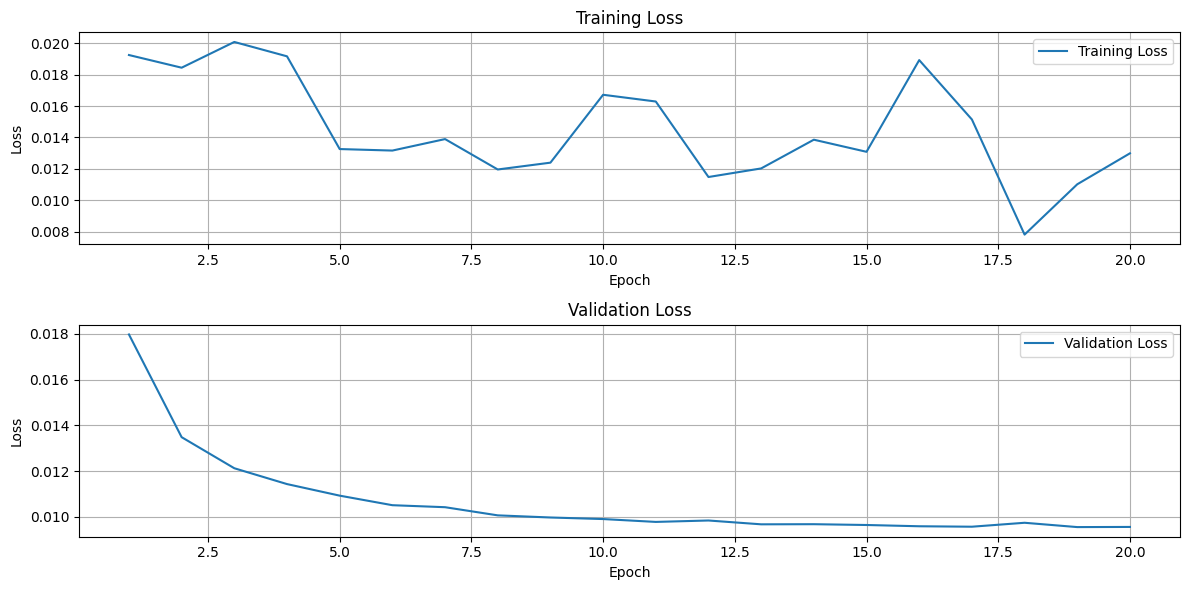

In [5]:
# plot loss over time
epochs = range(1, no_epochs + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(epochs, train_loss_list, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid()
ax1.legend()

ax2.plot(epochs, test_loss_list, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

Let's visualize the results by plotting the input and output of our model as well as the ground truth images.

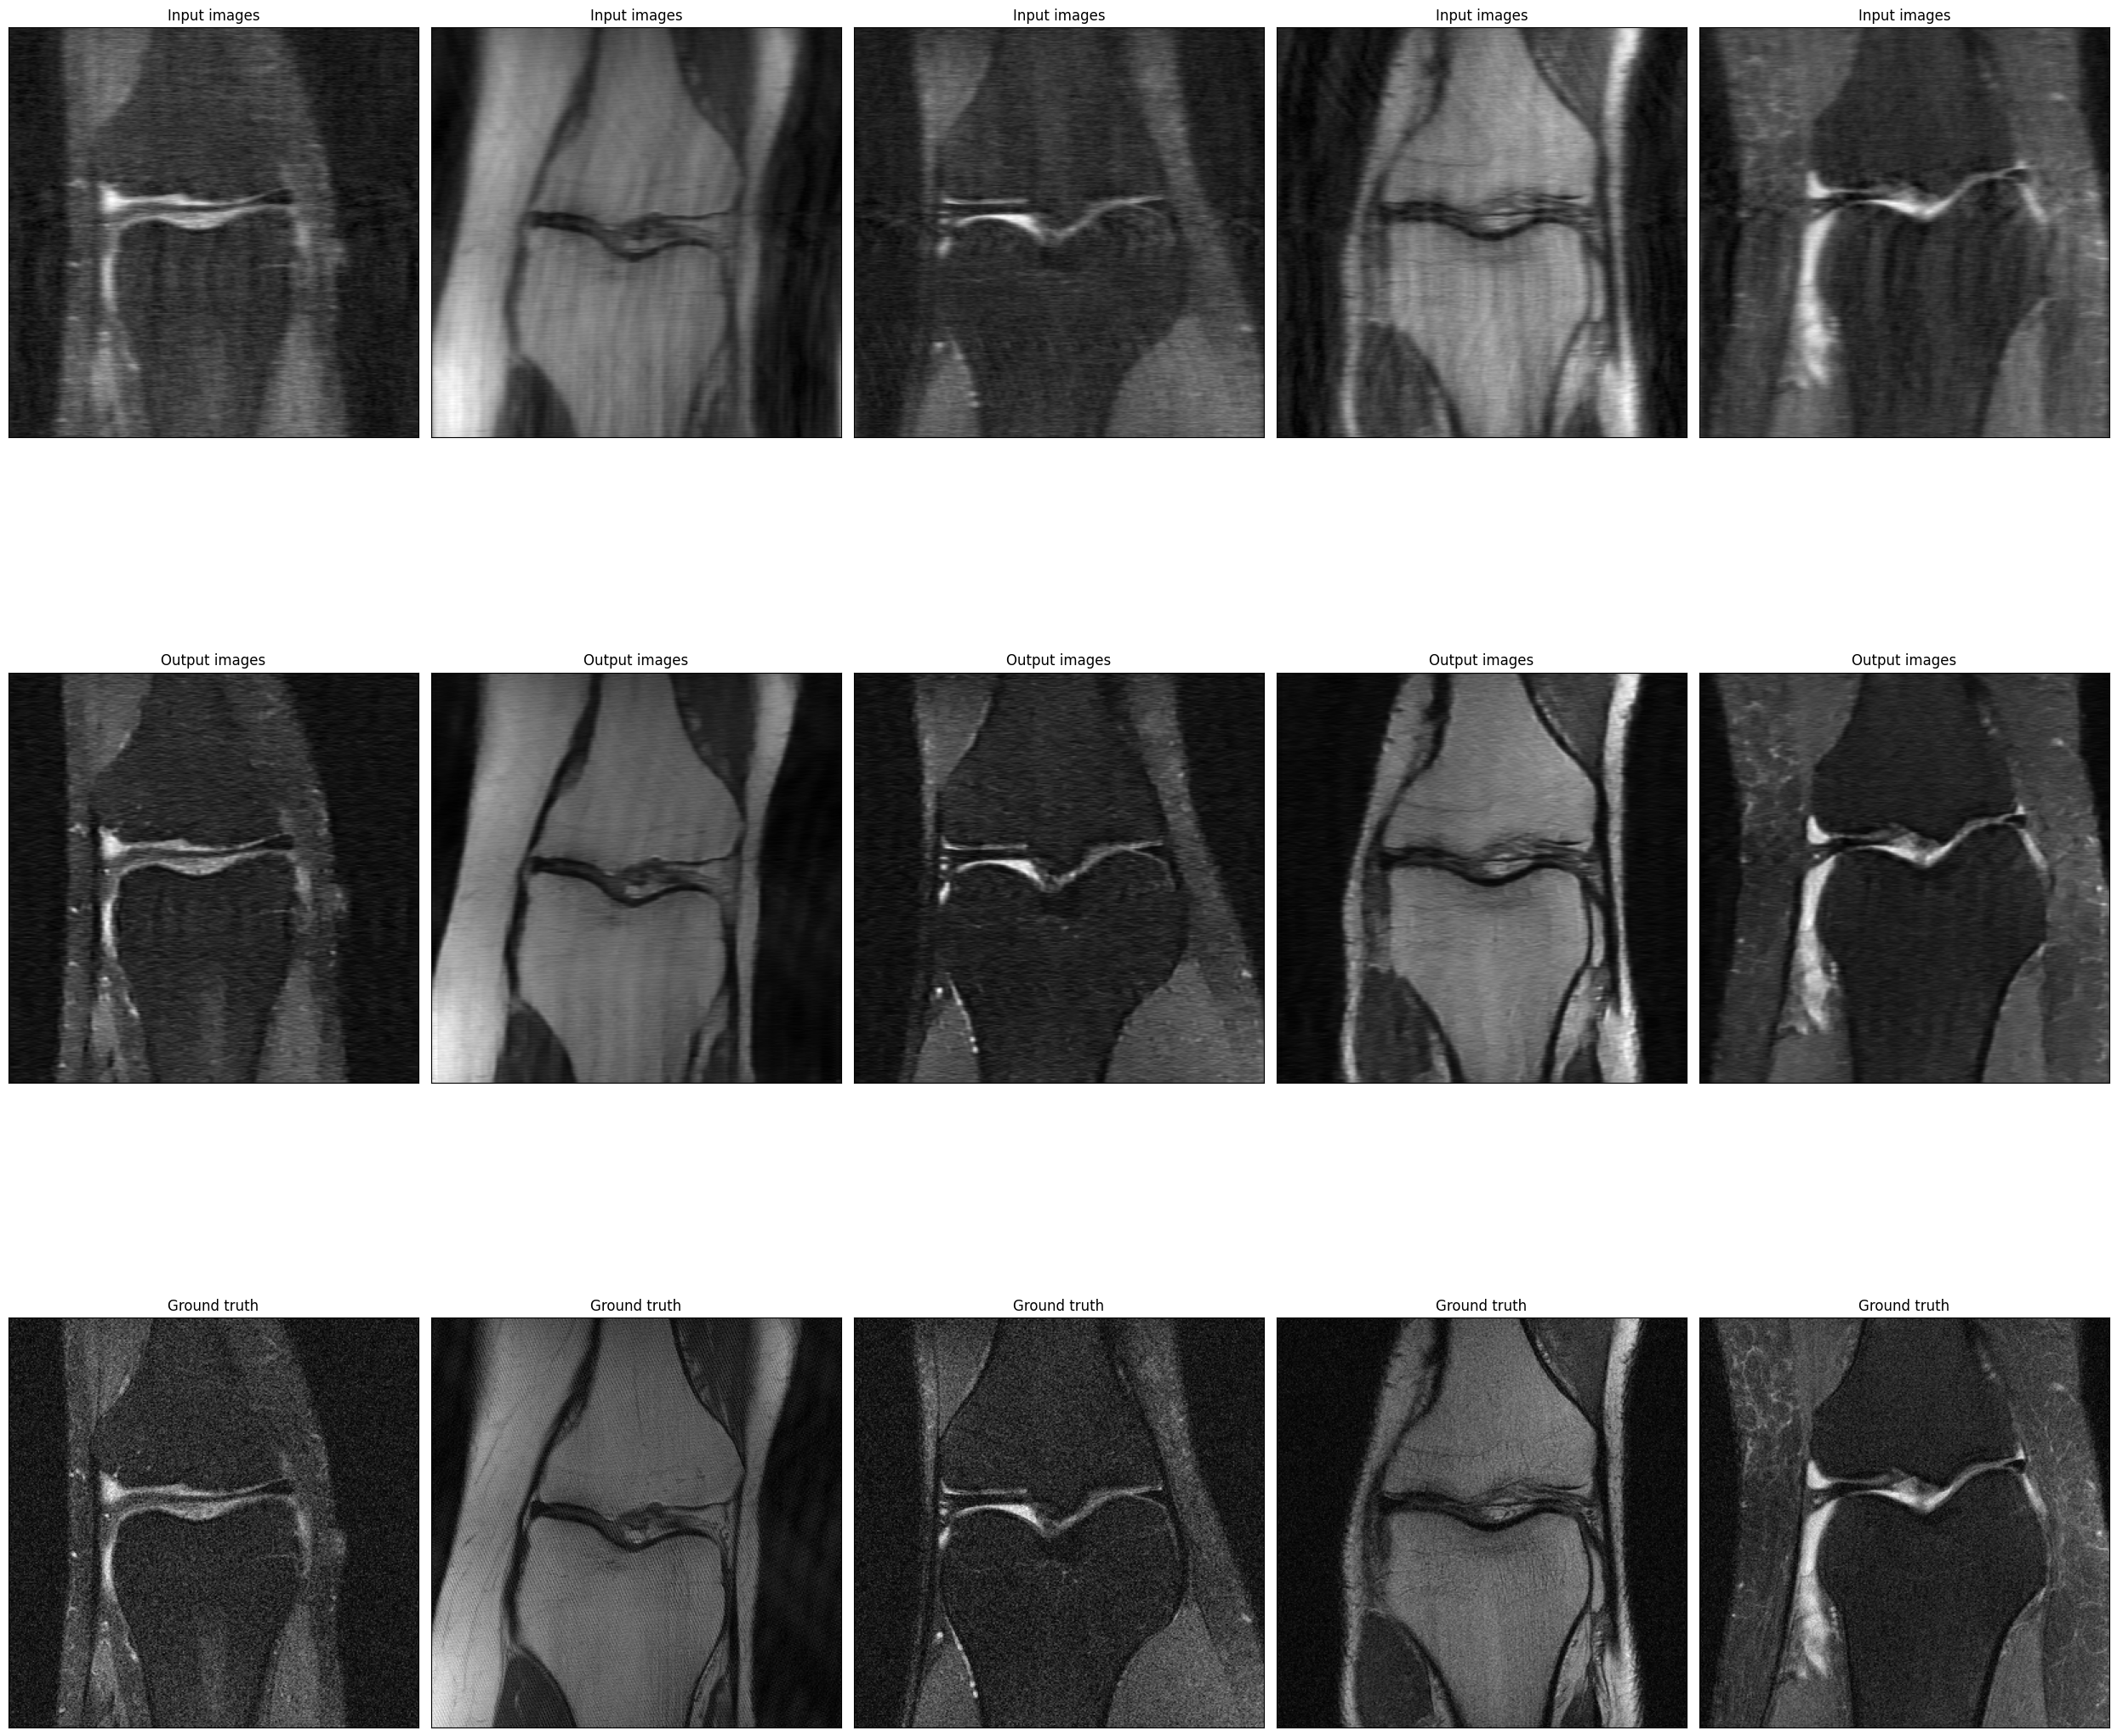

In [6]:
# get the first batch from the train loader
first_batch = next(iter(train_loader))
kspace, mask, ground_truth = first_batch

# take the first five ground truth images, k-spaces and measurement matrices of first batch
gt_images = ground_truth[0:5]
part_kspaces = kspace[0:5]
M_matrices = mask[0:5]

acc_MRI = MRI_helper.accelarate_MRI(part_kspaces).abs()

# add an extra dimension to the input tensors
acc_MRI = acc_MRI.abs().unsqueeze(1).to(device)
part_kspaces = part_kspaces.unsqueeze(1).to(device)
M_matrices = M_matrices.unsqueeze(1).to(device)
gt = gt_images.unsqueeze(1).to(device)

# reconstructions using prox net
with torch.no_grad():
    prox_net_recon = prox_net_model(part_kspaces, M_matrices, lamda)
    prox_net_recon = prox_net_recon.squeeze().detach().cpu().numpy()

plt.figure(figsize=(25, 25))
for i in range(5):
    # plot input image
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(acc_MRI[i, :, :].squeeze().cpu(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Input images')

    # plot output image
    ax = plt.subplot(3, 5, i + 6)
    plt.imshow(prox_net_recon[i, :, :], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Output images')

    # plot ground truth image
    ax = plt.subplot(3, 5, i + 11)
    plt.imshow(gt_images[i, :, :].cpu(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Ground truth')

# Display the figure
plt.tight_layout()
plt.savefig('results.png', dpi=300, bbox_inches='tight')
plt.show()

The last code block will calculate the Mean Squared Error of our trained model on the test set to get a better understanding of how well our trained model generalizes to unseen data.

In [7]:
# iterate over the test loader
with torch.no_grad():
    total_mse = 0
    for batch in test_loader:
        kspace, mask, ground_truth = batch

        # add an extra dimension to the input tensors
        kspace = kspace.unsqueeze(1).to(device)
        M = mask.unsqueeze(1).to(device)
        gt = ground_truth.unsqueeze(1).to(device)

        # reconstruct the images
        recon_images = prox_net_model(kspace, M, lamda).to(device)

        # calculate the MSE
        mse = torch.nn.functional.mse_loss(torch.abs(recon_images), torch.abs(gt))

        total_mse += mse.item()

# calculate the average MSE
average_mse = total_mse / len(test_loader)

print("Mean Squared Error (MSE):", average_mse)

Mean Squared Error (MSE): 0.009505203895030482


<a id="suggestions"></a>
# Suggestions for follow-up work and variations

- Experiment with deeper neural network architectures, involving more convolutional layers and filters, to capture more complex image features.
- Consider applying transfer learning by pre-training on a related dataset before fine-tuning on MRI data.
- Collect and incorporate a larger and more diverse dataset to improve the model's performance and generalization.